In [ ]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
plt.style.use("ggplot")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/11_data_pre_processing_for_openpose/ekman/openpose_all_results_merged_without_NaN.csv")
df.head()

,Unnamed: 0,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,...,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c,filename,emotion,videoname
0,0,1,731.249,198.399,0.850708,697.934,394.250,0.647540,547.098,388.432,0.472235,441.305,633.315,0.500294,319.825,715.615,0.220352,839.045,388.397,0.436088,905.637,629.376,0.322376,970.272,715.619,0.097874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01007,266.036,722.223,0.017656,254.293,716.352,0.010845,235.699,739.838,0.008400,229.828,739.838,0.008405,261.143,721.245,0.024683,254.293,716.352,0.012333,248.421,756.474,0.011577,242.550,759.410,0.009841,258.207,710.480,0.022670,253.314,725.159,0.014937,238.635,743.753,0.014931,236.678,745.710,0.011006,output_video107.csv,anger,video01
1,1,2,729.332,204.230,0.843643,697.924,398.201,0.642926,552.978,388.398,0.473893,445.279,641.127,0.537712,360.990,715.630,0.142488,838.998,400.168,0.442338,905.639,647.009,0.445984,964.342,715.633,0.091682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00743,347.284,736.185,0.018372,360.385,710.990,0.007789,316.042,793.630,0.007539,297.901,801.693,0.006193,338.213,738.201,0.026940,360.385,710.990,0.009862,316.042,785.568,0.010101,303.948,791.615,0.006913,338.213,740.216,0.030672,337.205,739.209,0.013722,315.034,781.536,0.009954,307.979,783.552,0.007570,output_video107.csv,anger,video01
2,2,3,729.285,206.162,0.852322,696.048,394.305,0.646629,549.073,390.386,0.453411,441.320,656.797,0.465288,0.000,0.000,0.000000,837.005,392.321,0.492424,897.794,637.200,0.353257,940.852,715.634,0.069541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,anger,video01
3,3,4,727.296,200.379,0.843100,695.904,388.418,0.641356,549.035,386.440,0.461498,447.248,652.873,0.382689,0.000,0.000,0.000000,835.056,388.400,0.498208,882.098,633.296,0.255498,913.474,715.622,0.120405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,anger,video01
4,4,5,723.424,196.431,0.855498,692.070,382.498,0.648065,545.154,384.500,0.494854,482.450,652.899,0.319641,0.000,0.000,0.000000,831.138,376.636,0.504424,858.628,582.348,0.347328,882.137,715.610,0.215963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000,0.000,0.000000,output_video107.csv,anger,video01


In [ ]:
X = df.drop(['Unnamed: 0', 'filename', 'videoname'], axis=1)
X["frame"] = X["frame"]-1
X = X.drop(['frame'], axis=1)
y = X.iloc[:, -1]
X = X.iloc[:, 0:-1]
y.head()

0    anger
1    anger
2    anger
3    anger
4    anger
Name: emotion, dtype: object

In [ ]:
# Encode Output Class
class2idx = {
    'anger':0,
    'joy':1,
    'neutral':2,
    'surprise':3,
    'disgust':4,
    'sadness':5,
    'fear':6
}

idx2class = {v: k for k, v in class2idx.items()}

y.replace(class2idx, inplace=True)
y.head()

0    0
1    0
2    0
3    0
4    0
Name: emotion, dtype: int64

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [ ]:
target_df =pd.read_csv("/content/drive/MyDrive/05_workspace/01_msc_project/data/output/09_openpose/ekman/video01/anger/output_video66.csv")
target_df.head()

,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,LHip_c,...,hr_point7_c,hr_point8_x,hr_point8_y,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c
0,1,617.508,196.424,0.894552,523.524,315.926,0.597233,458.912,308.098,0.539411,478.552,523.569,0.385198,466.743,690.116,0.360204,588.248,319.844,0.560446,648.927,525.581,0.595052,649.000,637.205,0.738793,537.271,686.192,0.137417,478.557,688.163,0.138721,0.0,0.0,0.0,0.0,0.0,0.0,598.021,680.330,0.147542,...,0.044640,435.859,718.090,0.015404,468.402,721.265,0.022592,458.877,717.296,0.036333,454.908,718.090,0.035522,440.621,722.852,0.016732,471.576,721.265,0.030540,470.783,712.534,0.029216,459.671,712.534,0.027363,442.209,722.852,0.013295,473.958,720.471,0.016420,478.720,710.946,0.017670,458.877,701.422,0.022120,458.877,703.009,0.012864
1,2,613.694,196.325,0.879938,521.605,317.845,0.635027,453.051,308.129,0.541191,476.596,519.666,0.328213,464.833,697.946,0.342683,588.250,319.859,0.612907,648.879,523.568,0.563729,650.893,635.334,0.758070,541.191,686.205,0.167224,484.417,684.245,0.167606,0.0,0.0,0.0,0.0,0.0,0.0,611.750,692.052,0.166710,...,0.025365,475.006,723.204,0.012481,464.856,727.108,0.015704,451.582,729.450,0.024619,453.144,734.916,0.020454,464.075,746.628,0.009386,475.006,727.888,0.016043,450.020,734.135,0.020861,450.020,734.916,0.013781,460.952,752.874,0.008763,482.814,717.738,0.012571,482.034,712.272,0.012104,462.513,754.436,0.010703,460.952,755.998,0.008447
2,3,607.812,194.369,0.859384,519.630,315.876,0.591369,451.132,308.058,0.539635,478.518,507.933,0.340606,464.860,688.163,0.330604,586.234,319.776,0.577226,646.952,523.616,0.584049,650.916,635.332,0.762901,529.452,686.192,0.154871,476.548,682.285,0.152499,0.0,0.0,0.0,0.0,0.0,0.0,599.982,678.344,0.160307,...,0.025179,441.850,718.035,0.013228,471.454,726.916,0.020259,458.132,721.736,0.028106,450.731,732.097,0.025260,438.150,729.877,0.010606,489.956,732.837,0.015450,455.172,733.577,0.021737,467.013,742.458,0.015645,468.493,747.639,0.009766,424.828,755.040,0.013809,505.498,726.176,0.011898,471.454,745.419,0.011532,438.890,758.000,0.009574
3,4,603.959,190.514,0.864136,513.826,313.953,0.583764,449.163,306.173,0.526487,470.712,523.557,0.378256,462.887,682.255,0.408752,584.300,319.783,0.601879,637.279,515.750,0.549286,650.896,635.332,0.752173,529.473,674.441,0.159926,476.543,672.481,0.165613,0.0,0.0,0.0,0.0,0.0,0.0,594.127,668.554,0.161768,...,0.019054,443.476,716.194,0.011390,482.743,736.228,0.013003,458.702,735.427,0.017194,453.092,732.221,0.021339,444.277,712.988,0.008239,483.544,734.626,0.012776,461.106,738.633,0.013721,469.120,739.434,0.011310,457.900,753.859,0.007227,485.147,736.228,0.010585,487.551,709.783,0.008905,457.099,755.461,0.009389,459.503,761.071,0.007818
4,5,603.926,188.551,0.863411,513.797,312.008,0.601255,449.159,308.062,0.536185,472.667,507.930,0.316025,462.828,678.375,0.408244,582.377,317.840,0.590049,635.290,519.639,0.588100,649.026,639.150,0.733526,535.322,666.615,0.169263,478.530,668.558,0.159247,0.0,0.0,0.0,0.0,0.0,0.0,598.040,666.594,0.163558,...,0.013390,433.742,722.810,0.008743,473.608,725.025,0.013108,450.722,718.380,0.016502,445.554,734.622,0.013318,434.480,730.193,0.008106,474.347,723.548,0.012684,449.246,725.763,0.014040,444.078,726.501,0.010484,438.910,730.931,0.007113,478.776,708.783,0.011604,480.

In [ ]:
target_df["frame"]=target_df["frame"]-1
target_df.head()

,frame,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,LHip_c,...,hr_point7_c,hr_point8_x,hr_point8_y,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c
0,0,617.508,196.424,0.894552,523.524,315.926,0.597233,458.912,308.098,0.539411,478.552,523.569,0.385198,466.743,690.116,0.360204,588.248,319.844,0.560446,648.927,525.581,0.595052,649.000,637.205,0.738793,537.271,686.192,0.137417,478.557,688.163,0.138721,0.0,0.0,0.0,0.0,0.0,0.0,598.021,680.330,0.147542,...,0.044640,435.859,718.090,0.015404,468.402,721.265,0.022592,458.877,717.296,0.036333,454.908,718.090,0.035522,440.621,722.852,0.016732,471.576,721.265,0.030540,470.783,712.534,0.029216,459.671,712.534,0.027363,442.209,722.852,0.013295,473.958,720.471,0.016420,478.720,710.946,0.017670,458.877,701.422,0.022120,458.877,703.009,0.012864
1,1,613.694,196.325,0.879938,521.605,317.845,0.635027,453.051,308.129,0.541191,476.596,519.666,0.328213,464.833,697.946,0.342683,588.250,319.859,0.612907,648.879,523.568,0.563729,650.893,635.334,0.758070,541.191,686.205,0.167224,484.417,684.245,0.167606,0.0,0.0,0.0,0.0,0.0,0.0,611.750,692.052,0.166710,...,0.025365,475.006,723.204,0.012481,464.856,727.108,0.015704,451.582,729.450,0.024619,453.144,734.916,0.020454,464.075,746.628,0.009386,475.006,727.888,0.016043,450.020,734.135,0.020861,450.020,734.916,0.013781,460.952,752.874,0.008763,482.814,717.738,0.012571,482.034,712.272,0.012104,462.513,754.436,0.010703,460.952,755.998,0.008447
2,2,607.812,194.369,0.859384,519.630,315.876,0.591369,451.132,308.058,0.539635,478.518,507.933,0.340606,464.860,688.163,0.330604,586.234,319.776,0.577226,646.952,523.616,0.584049,650.916,635.332,0.762901,529.452,686.192,0.154871,476.548,682.285,0.152499,0.0,0.0,0.0,0.0,0.0,0.0,599.982,678.344,0.160307,...,0.025179,441.850,718.035,0.013228,471.454,726.916,0.020259,458.132,721.736,0.028106,450.731,732.097,0.025260,438.150,729.877,0.010606,489.956,732.837,0.015450,455.172,733.577,0.021737,467.013,742.458,0.015645,468.493,747.639,0.009766,424.828,755.040,0.013809,505.498,726.176,0.011898,471.454,745.419,0.011532,438.890,758.000,0.009574
3,3,603.959,190.514,0.864136,513.826,313.953,0.583764,449.163,306.173,0.526487,470.712,523.557,0.378256,462.887,682.255,0.408752,584.300,319.783,0.601879,637.279,515.750,0.549286,650.896,635.332,0.752173,529.473,674.441,0.159926,476.543,672.481,0.165613,0.0,0.0,0.0,0.0,0.0,0.0,594.127,668.554,0.161768,...,0.019054,443.476,716.194,0.011390,482.743,736.228,0.013003,458.702,735.427,0.017194,453.092,732.221,0.021339,444.277,712.988,0.008239,483.544,734.626,0.012776,461.106,738.633,0.013721,469.120,739.434,0.011310,457.900,753.859,0.007227,485.147,736.228,0.010585,487.551,709.783,0.008905,457.099,755.461,0.009389,459.503,761.071,0.007818
4,4,603.926,188.551,0.863411,513.797,312.008,0.601255,449.159,308.062,0.536185,472.667,507.930,0.316025,462.828,678.375,0.408244,582.377,317.840,0.590049,635.290,519.639,0.588100,649.026,639.150,0.733526,535.322,666.615,0.169263,478.530,668.558,0.159247,0.0,0.0,0.0,0.0,0.0,0.0,598.040,666.594,0.163558,...,0.013390,433.742,722.810,0.008743,473.608,725.025,0.013108,450.722,718.380,0.016502,445.554,734.622,0.013318,434.480,730.193,0.008106,474.347,723.548,0.012684,449.246,725.763,0.014040,444.078,726.501,0.010484,438.910,730.931,0.007113,478.776,708.783,0.011604,480.

In [ ]:
X_target = target_df.drop(['frame'], axis=1)
X_target.head()

,Nose_x,Nose_y,Nose_c,Neck_x,Neck_y,Neck_c,RShoulder_x,RShoulder_y,RShoulder_c,RElbow_x,RElbow_y,RElbow_c,RWrist_x,RWrist_y,RWrist_c,LShoulder_x,LShoulder_y,LShoulder_c,LElbow_x,LElbow_y,LElbow_c,LWrist_x,LWrist_y,LWrist_c,MidHip_x,MidHip_y,MidHip_c,RHip_x,RHip_y,RHip_c,RKnee_x,RKnee_y,RKnee_c,RAnkle_x,RAnkle_y,RAnkle_c,LHip_x,LHip_y,LHip_c,LKnee_x,...,hr_point7_c,hr_point8_x,hr_point8_y,hr_point8_c,hr_point9_x,hr_point9_y,hr_point9_c,hr_point10_x,hr_point10_y,hr_point10_c,hr_point11_x,hr_point11_y,hr_point11_c,hr_point12_x,hr_point12_y,hr_point12_c,hr_point13_x,hr_point13_y,hr_point13_c,hr_point14_x,hr_point14_y,hr_point14_c,hr_point15_x,hr_point15_y,hr_point15_c,hr_point16_x,hr_point16_y,hr_point16_c,hr_point17_x,hr_point17_y,hr_point17_c,hr_point18_x,hr_point18_y,hr_point18_c,hr_point19_x,hr_point19_y,hr_point19_c,hr_point20_x,hr_point20_y,hr_point20_c
0,617.508,196.424,0.894552,523.524,315.926,0.597233,458.912,308.098,0.539411,478.552,523.569,0.385198,466.743,690.116,0.360204,588.248,319.844,0.560446,648.927,525.581,0.595052,649.000,637.205,0.738793,537.271,686.192,0.137417,478.557,688.163,0.138721,0.0,0.0,0.0,0.0,0.0,0.0,598.021,680.330,0.147542,0.0,...,0.044640,435.859,718.090,0.015404,468.402,721.265,0.022592,458.877,717.296,0.036333,454.908,718.090,0.035522,440.621,722.852,0.016732,471.576,721.265,0.030540,470.783,712.534,0.029216,459.671,712.534,0.027363,442.209,722.852,0.013295,473.958,720.471,0.016420,478.720,710.946,0.017670,458.877,701.422,0.022120,458.877,703.009,0.012864
1,613.694,196.325,0.879938,521.605,317.845,0.635027,453.051,308.129,0.541191,476.596,519.666,0.328213,464.833,697.946,0.342683,588.250,319.859,0.612907,648.879,523.568,0.563729,650.893,635.334,0.758070,541.191,686.205,0.167224,484.417,684.245,0.167606,0.0,0.0,0.0,0.0,0.0,0.0,611.750,692.052,0.166710,0.0,...,0.025365,475.006,723.204,0.012481,464.856,727.108,0.015704,451.582,729.450,0.024619,453.144,734.916,0.020454,464.075,746.628,0.009386,475.006,727.888,0.016043,450.020,734.135,0.020861,450.020,734.916,0.013781,460.952,752.874,0.008763,482.814,717.738,0.012571,482.034,712.272,0.012104,462.513,754.436,0.010703,460.952,755.998,0.008447
2,607.812,194.369,0.859384,519.630,315.876,0.591369,451.132,308.058,0.539635,478.518,507.933,0.340606,464.860,688.163,0.330604,586.234,319.776,0.577226,646.952,523.616,0.584049,650.916,635.332,0.762901,529.452,686.192,0.154871,476.548,682.285,0.152499,0.0,0.0,0.0,0.0,0.0,0.0,599.982,678.344,0.160307,0.0,...,0.025179,441.850,718.035,0.013228,471.454,726.916,0.020259,458.132,721.736,0.028106,450.731,732.097,0.025260,438.150,729.877,0.010606,489.956,732.837,0.015450,455.172,733.577,0.021737,467.013,742.458,0.015645,468.493,747.639,0.009766,424.828,755.040,0.013809,505.498,726.176,0.011898,471.454,745.419,0.011532,438.890,758.000,0.009574
3,603.959,190.514,0.864136,513.826,313.953,0.583764,449.163,306.173,0.526487,470.712,523.557,0.378256,462.887,682.255,0.408752,584.300,319.783,0.601879,637.279,515.750,0.549286,650.896,635.332,0.752173,529.473,674.441,0.159926,476.543,672.481,0.165613,0.0,0.0,0.0,0.0,0.0,0.0,594.127,668.554,0.161768,0.0,...,0.019054,443.476,716.194,0.011390,482.743,736.228,0.013003,458.702,735.427,0.017194,453.092,732.221,0.021339,444.277,712.988,0.008239,483.544,734.626,0.012776,461.106,738.633,0.013721,469.120,739.434,0.011310,457.900,753.859,0.007227,485.147,736.228,0.010585,487.551,709.783,0.008905,457.099,755.461,0.009389,459.503,761.071,0.007818
4,603.926,188.551,0.863411,513.797,312.008,0.601255,449.159,308.062,0.536185,472.667,507.930,0.316025,462.828,678.375,0.408244,582.377,317.840,0.590049,635.290,519.639,0.588100,649.026,639.150,0.733526,535.322,666.615,0.169263,478.530,668.558,0.159247,0.0,0.0,0.0,0.0,0.0,0.0,598.040,666.594,0.163558,0.0,...,0.013390,433.742,722.810,0.008743,473.608,725.025,0.013108,450.722,718.380,0.016502,445.554,734.622,0.013318,434.480,730.193,0.008106,474.347,723.548,0.012684,449.246,725.763,0.014040,444.078,726.501,0.010484,438.910,730.931,0.007113,478.776,708.783,0

In [ ]:
X_target = scaler.transform(X_target)
X_target = np.array(X_target)
X_targetdataset = torch.from_numpy(X_target).float()

In [ ]:
# Model Parameters
EPOCHS = 300 #original 300
BATCH_SIZE = 32 #original 16
LEARNING_RATE = 0.01

NUM_FEATURES = 411
NUM_CLASSES = 7

In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        self.fc1 = nn.Linear(num_feature, 400)  # All bonding layers
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, num_class)

        self.batchnorm1 = nn.BatchNorm1d(200)

    def forward(self, x):# number of inputs
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.batchnorm1(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [ ]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.cuda()  # GPU
print(model)

MulticlassClassification(
  (fc1): Linear(in_features=411, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=7, bias=True)
  (batchnorm1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
#model load
modelpath = "/content/drive/MyDrive/05_workspace/01_msc_project/data/output/14_predict_emotion_from_pose/ekman/model02(3NN_Epoch300)/pytorch_epoch300_model.pth"
model.load_state_dict(torch.load(modelpath, map_location=device))

<All keys matched successfully>

In [ ]:
correct = 0
total = 0

y_pred = []
y_true = []

columnlist = ["anger_c","joy_c","neutral_c","surprise_c","disgust_c","sadness_c","fear_c"]
plot_df = pd.DataFrame(columns=columnlist)

#anger:0,joy:1,nuetral:2,surprise:3,disgust:4,sadness:5,fear:6
label = 0

for i, x in enumerate(X_targetdataset):
    #print (x[0,:])
    x= x.cuda()  # GPU
    x = x.view(-1,NUM_FEATURES)
    y = model(x)

    #append confidence
    plot_df = plot_df.append(pd.DataFrame(torch.exp(y).data.cpu().numpy(),columns=columnlist))

    output = (torch.max(torch.exp(y), 1)[1]).data.cpu().numpy()
    #output = (y.argmax(1)).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    #print (output)
        
    y_true.extend(np.array([label])) # Save Truth
    #print (labels)

    correct += (y.argmax(1) == label).sum().item()

    total += len(x)
    
print("正解率:", str(correct/total*100) + "%")

正解率: 74.66666666666667%


[[56  5 12  1  1]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]


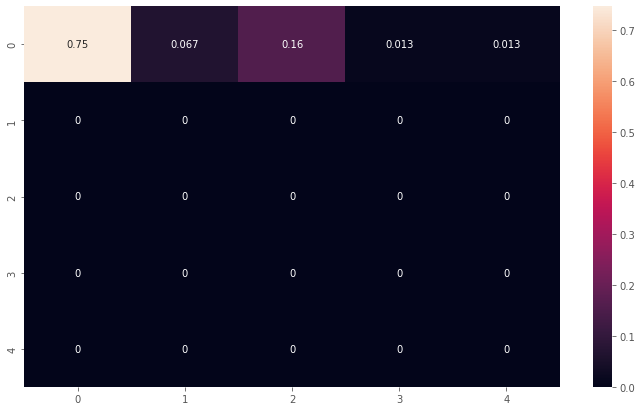

In [ ]:
import seaborn as sn
classes = ('anger', 'joy', 'neutral', 'surprise', 'disgust',
        'saddness', 'fear')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print (cf_matrix)
#df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) , index = [i for i in classes],
                    # columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix/(i+1), annot=True)

In [ ]:
plot_df.head()

,anger_c,joy_c,neutral_c,surprise_c,disgust_c,sadness_c,fear_c
0,0.990965,0.000008,0.009019,0.000008,4.690955e-13,1.437912e-07,7.876291e-17
0,0.965826,0.000059,0.034064,0.000051,1.070413e-12,1.732908e-07,3.456486e-17
0,0.719615,0.000359,0.279423,0.000577,2.776880e-11,2.573640e-05,4.740614e-17
0,0.673314,0.000147,0.325829,0.000700,3.062350e-11,1.005274e-05,9.886324e-16
0,0.356710,0.002450,0.578204,0.062216,1.788496e-11,4.200099e-04,1.080177e-16


In [ ]:
plot_df = plot_df.reset_index()

In [ ]:
plot_df = plot_df.drop("index",axis=1)
plot_df.head()

,anger_c,joy_c,neutral_c,surprise_c,disgust_c,sadness_c,fear_c
0,0.990965,0.000008,0.009019,0.000008,4.690955e-13,1.437912e-07,7.876291e-17
1,0.965826,0.000059,0.034064,0.000051,1.070413e-12,1.732908e-07,3.456486e-17
2,0.719615,0.000359,0.279423,0.000577,2.776880e-11,2.573640e-05,4.740614e-17
3,0.673314,0.000147,0.325829,0.000700,3.062350e-11,1.005274e-05,9.886324e-16
4,0.356710,0.002450,0.578204,0.062216,1.788496e-11,4.200099e-04,1.080177e-16


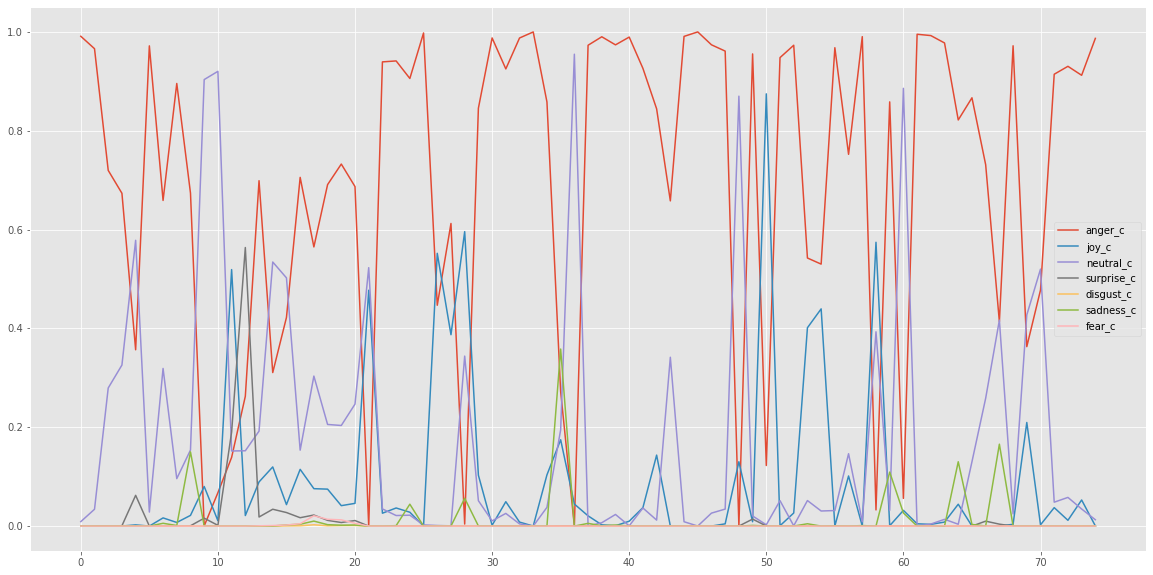

In [ ]:
plot_df.plot(figsize=(20, 10))

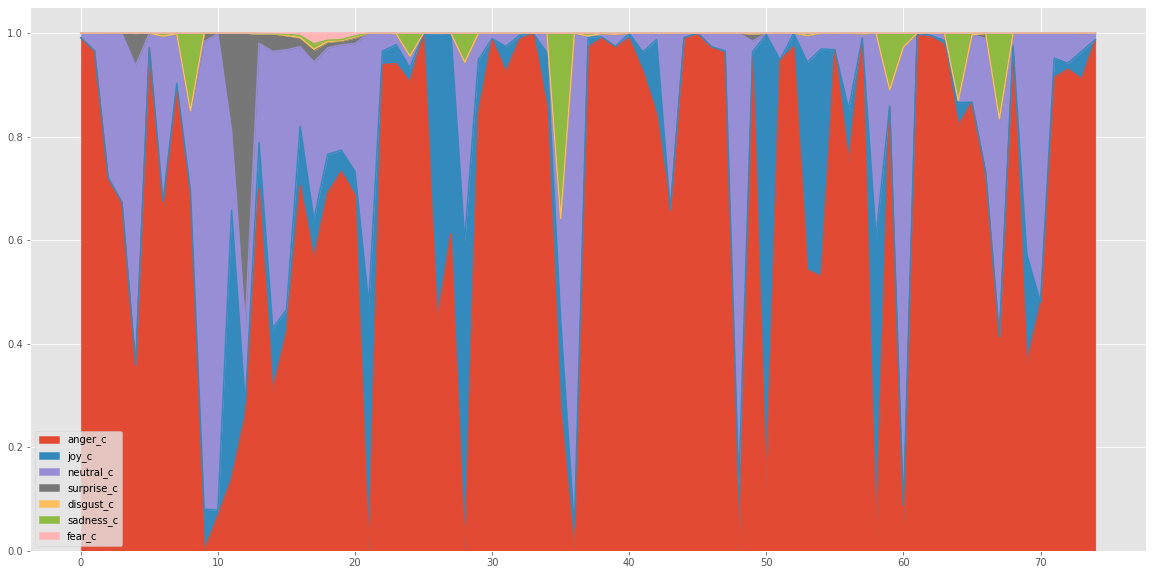

In [ ]:
plot_df.plot(kind='area',figsize=(20, 10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f62a0c4d5d0>,
      dtype=object)

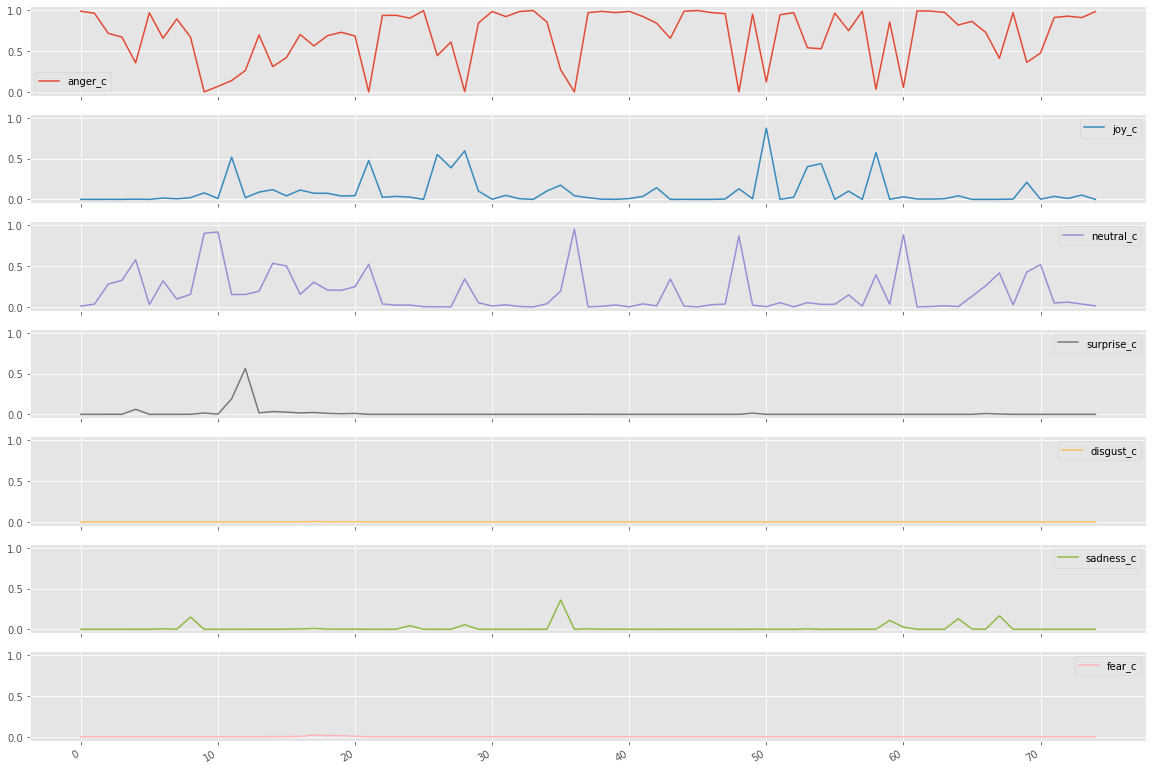

In [ ]:

plot_df.plot(subplots=True, sharey=True,figsize=(20, 15))